# Interpolate ESG

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

## Import Data

In [2]:
sa = pd.read_csv("../data/minas_esg/sustainalytics_CIQ_ID.csv", encoding="latin-1")
sa["Date"] = sa["Date"].apply(lambda x: datetime.strptime(str(x), "%Y%m%d"))
sa

,CapitalIQ_ID,Date,Company,ISIN,Ticker,total_esg_score,governance_score,social_score,environment_score
0,IQ10004874,2016-10-04,"SolarWinds, Inc.",SUST8848CCF3,NaN,48.12,74.83,40.92,36.67
1,IQ10004874,2016-11-16,"SolarWinds, Inc.",SUST8848CCF3,NaN,48.12,74.83,40.92,36.67
2,IQ10004874,2016-12-08,"SolarWinds, Inc.",US83416B1098,NaN,48.12,74.83,40.92,36.67
3,IQ10004874,2017-01-11,"SolarWinds, Inc.",US83416B1098,NaN,48.12,74.83,40.92,36.67
4,IQ10004874,2017-02-02,"SolarWinds, Inc.",US83416B1098,NaN,48.12,74.83,40.92,36.67
...,...,...,...,...,...,...,...,...,...
104665,IQ997111,2019-06-03,A. O. Smith Corporation,US8318652091,AOS,46.69,58.89,41.00,44.04
104666,IQ997111,2019-07-01,A. O. Smith Corporation,US8318652091,AOS,46.61,58.59,41.00,44.04
104667,IQ997111,2019-08-01,A. O. Smith Corporation,US8318652091,AOS,46.61,58.59,41.00,44.04
104668,IQ997111,2019-09-02,A. O. Smith Corporation,US8318652091,AOS,46.61,58.59,41.00,44.04


In [3]:
bs_pos = pd.read_csv("../data/bs_data_w_positions.csv")
bs_pos["evtdate"] = pd.to_datetime(bs_pos["evtdate"])
bs_pos["evtdate_end"] = pd.to_datetime(bs_pos["evtdate_end"])
bs_pos["amount"] = np.abs(bs_pos["transaction"])
bs_pos["buy"] = (bs_pos["transaction"] > 0).astype(int)
bs_pos

,index,ticker,permno,asset,cid,firstname,lastname,fecid,evtdate,evtdate_end,transaction,position,init_pos,amount,buy
0,0,HD,66181.0,NaN,N00030768,Martha,Roby,H0AL02087,2018-08-28,2020-12-31,-8000.5,-8000.5,1,8000.5,0
1,1,GE,12060.0,NaN,N00030768,Martha,Roby,H0AL02087,2018-08-28,2020-12-31,-8000.5,-8000.5,1,8000.5,0
2,2,VALE,89330.0,NaN,N00030768,Martha,Roby,H0AL02087,2018-08-28,2020-12-31,-115.0,-115.0,1,115.0,0
3,3,F,25785.0,NaN,N00030768,Martha,Roby,H0AL02087,2018-08-28,2020-12-31,-8000.5,-8000.5,1,8000.5,0
4,0,AI,85653.0,NaN,N00030910,Mo,Brooks,H0AL05163,2013-06-10,2013-09-13,-1000.0,-1000.0,1,1000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50095,3,PFE,21936.0,NaN,N00038734,Jacky,Rosen,S8NV00156,2020-11-17,2020-12-31,0.0,0.0,1,0.0,0
50096,0,RNWK,85576.0,NaN,N00007836,Maria,Cantwell,S8WA00194,2013-06-17,2014-01-07,-4000.0,-4000.0,1,4000.0,0
50097,1,RNWK,85576.0,NaN,N00007836,Maria,Cantwell,S8WA00194,2014-01-07,2014-06-06,-2000.0,-6000.0,0,2000.0,0
50098,2,RNWK,85576.0,NaN,N00007836,Maria,Cantwell,S8WA00194,2014-06-06,2016-04-28,-4000.0,-10000.0,0,4000.0,0


## Interpolate ESG Scores

In [4]:
IDENTIFIER = ["ticker", "Ticker"] # TODO: Ask Mina about PERMNO
def interpolate_esg(stock):
    
    # prepare bs_data side
    bs_stock = bs_pos[bs_pos[IDENTIFIER[0]]==stock].copy()
    bs_stock_dates = bs_stock[["evtdate"]].dropna().copy()
    bs_stock_dates = bs_stock_dates.rename(columns={"evtdate": "Date"})
    
    # prepare esg data side
    esg_stock = sa[sa[IDENTIFIER[1]]==stock][["Date", "total_esg_score"]].dropna().reset_index(drop=True).copy()
    
    # get the common date in the two data frames
    common = esg_stock.merge(bs_stock_dates.drop_duplicates(), how='outer').set_index("Date")

    # interpolate the value
    common = common.resample('d').interpolate(method='time').reset_index()

    # merge
    res = common.merge(bs_stock, how='right', left_on="Date", right_on="evtdate")
    
    return res

### Example 1: Apple

In [5]:
interpolate_esg("AAPL")

,Date,total_esg_score,index,ticker,permno,asset,cid,firstname,lastname,fecid,evtdate,evtdate_end,transaction,position,init_pos,amount,buy
0,2020-04-13,72.270000,82,AAPL,14593.0,NaN,N00030910,Mo,Brooks,H0AL05163,2020-04-13,2020-12-31,-1000.0,-1000.0,1,1000.0,0
1,2020-11-24,72.270000,27,AAPL,14593.0,NaN,N00044298,Michael,Garcia,H0CA25105,2020-11-24,2020-12-31,15000.0,15000.0,1,15000.0,1
2,2014-06-16,61.000000,9,AAPL,14593.0,NaN,N00009585,Adam,Schiff,H0CA27085,2014-06-16,2014-08-18,-32500.5,-32500.5,1,32500.5,0
3,2014-08-18,61.000000,10,AAPL,14593.0,Apple Inc,N00009585,Adam,Schiff,H0CA27085,2014-08-18,2014-10-22,-32500.5,-65001.0,0,32500.5,0
4,2014-10-22,60.321429,11,AAPL,14593.0,NaN,N00009585,Adam,Schiff,H0CA27085,2014-10-22,2014-11-17,-32500.5,-97501.5,0,32500.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,2013-07-09,59.000000,604,AAPL,14593.0,NaN,N00029617,Kay,Hagan,S8NC00239,2013-07-09,2013-12-13,-1000.0,29002.0,0,1000.0,0
802,2013-12-13,58.000000,818,AAPL,14593.0,NaN,N00029617,Kay,Hagan,S8NC00239,2013-12-13,2014-02-11,8000.5,37002.5,0,8000.5,1
803,2014-02-11,59.000000,848,AAPL,14593.0,NaN,N00029617,Kay,Hagan,S8NC00239,2014-02-11,2014-06-25,1000.0,38002.5,0,1000.0,1
804,2014-06-25,61.000000,1054,AAPL,14593.0,NaN,N00029617,Kay,Hagan,S8NC00239,2014-06-25,2014-08-20,1000.0,39002.5,0,1000.0,1


### Example 2: RealNetworks Inc

In [6]:
interpolate_esg("RNWK")

,Date,total_esg_score,index,ticker,permno,asset,cid,firstname,lastname,fecid,evtdate,evtdate_end,transaction,position,init_pos,amount,buy
0,2013-06-17,NaN,0,RNWK,85576.0,NaN,N00007836,Maria,Cantwell,S8WA00194,2013-06-17,2014-01-07,-4000.0,-4000.0,1,4000.0,0
1,2014-01-07,NaN,1,RNWK,85576.0,NaN,N00007836,Maria,Cantwell,S8WA00194,2014-01-07,2014-06-06,-2000.0,-6000.0,0,2000.0,0
2,2014-06-06,NaN,2,RNWK,85576.0,NaN,N00007836,Maria,Cantwell,S8WA00194,2014-06-06,2016-04-28,-4000.0,-10000.0,0,4000.0,0
3,2016-04-28,48.08,3,RNWK,85576.0,NaN,N00007836,Maria,Cantwell,S8WA00194,2016-04-28,2020-12-31,-1000.0,-11000.0,0,1000.0,0


In [7]:
sa[sa["Ticker"]=="RNWK"]

,CapitalIQ_ID,Date,Company,ISIN,Ticker,total_esg_score,governance_score,social_score,environment_score
68406,IQ33660,2016-04-22,RealNetworks Inc.,NaN,RNWK,48.08,NaN,NaN,NaN


## Interpolate All Stocks

In [8]:
bs_pos_stock = bs_pos[IDENTIFIER[0]].unique()
sa_stock = sa[IDENTIFIER[1]].unique()
bs_pos_stock, sa_stock

(array(['HD', 'GE', 'VALE', ..., 'MSCC', 'CAKE', 'RNWK'], dtype=object),
 array([nan, 'SWI', 'ENV', ..., 'MGI', 'AOS', 'LGIH'], dtype=object))

In [9]:
bs_pos_esg = pd.DataFrame(columns=interpolate_esg("AAPL").columns)
duplicate_ticker_stocks = []
for stock in tqdm(bs_pos_stock, desc="Interpolating ESG Scores"):
    if stock in sa_stock:
        
        # handles exception arised because of duplicate tickers
        # skip the stock
        # this should not be a problem if using permno
        try: 
            bs_pos_esg_stock = interpolate_esg(stock)
        except:
            duplicate_ticker_stocks += [stock]
            continue
        
        bs_pos_esg = pd.concat([bs_pos_esg, interpolate_esg(stock)])

bs_pos_esg

Interpolating ESG Scores:   0%|          | 0/3067 [00:00<?, ?it/s]

,Date,total_esg_score,index,ticker,permno,asset,cid,firstname,lastname,fecid,evtdate,evtdate_end,transaction,position,init_pos,amount,buy
0,2018-08-28,67.234545,0,HD,66181.0,NaN,N00030768,Martha,Roby,H0AL02087,2018-08-28,2020-12-31,-8000.5,-8000.5,1,8000.5,0
1,2013-05-24,68.000000,148,HD,66181.0,NaN,N00003473,Hal,Rogers,H0KY05015,2013-05-24,2014-03-07,3164.0,3164.0,1,3164.0,1
2,2014-03-07,66.000000,359,HD,66181.0,NaN,N00003473,Hal,Rogers,H0KY05015,2014-03-07,2014-04-03,1494.0,4658.0,0,1494.0,1
3,2014-04-03,66.000000,393,HD,66181.0,NaN,N00003473,Hal,Rogers,H0KY05015,2014-04-03,2014-05-21,-475.0,4183.0,0,475.0,0
4,2014-05-21,65.607143,429,HD,66181.0,NaN,N00003473,Hal,Rogers,H0KY05015,2014-05-21,2014-06-04,923.0,5106.0,0,923.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2014-12-09,NaN,1385,CAKE,77902.0,NaN,N00029617,Kay,Hagan,S8NC00239,2014-12-09,2020-12-31,-1000.0,-1000.0,1,1000.0,0
0,2013-06-17,NaN,0,RNWK,85576.0,NaN,N00007836,Maria,Cantwell,S8WA00194,2013-06-17,2014-01-07,-4000.0,-4000.0,1,4000.0,0
1,2014-01-07,NaN,1,RNWK,85576.0,NaN,N00007836,Maria,Cantwell,S8WA00194,2014-01-07,2014-06-06,-2000.0,-6000.0,0,2000.0,0
2,2014-06-06,NaN,2,RNWK,85576.0,NaN,N00007836,Maria,Cantwell,S8WA00194,2014-06-06,2016-04-28,-4000.0,-10000.0,0,4000.0,0


In [10]:
bs_pos_esg = bs_pos_esg.reset_index(drop=True)
bs_pos_esg

,Date,total_esg_score,index,ticker,permno,asset,cid,firstname,lastname,fecid,evtdate,evtdate_end,transaction,position,init_pos,amount,buy
0,2018-08-28,67.234545,0,HD,66181.0,NaN,N00030768,Martha,Roby,H0AL02087,2018-08-28,2020-12-31,-8000.5,-8000.5,1,8000.5,0
1,2013-05-24,68.000000,148,HD,66181.0,NaN,N00003473,Hal,Rogers,H0KY05015,2013-05-24,2014-03-07,3164.0,3164.0,1,3164.0,1
2,2014-03-07,66.000000,359,HD,66181.0,NaN,N00003473,Hal,Rogers,H0KY05015,2014-03-07,2014-04-03,1494.0,4658.0,0,1494.0,1
3,2014-04-03,66.000000,393,HD,66181.0,NaN,N00003473,Hal,Rogers,H0KY05015,2014-04-03,2014-05-21,-475.0,4183.0,0,475.0,0
4,2014-05-21,65.607143,429,HD,66181.0,NaN,N00003473,Hal,Rogers,H0KY05015,2014-05-21,2014-06-04,923.0,5106.0,0,923.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41549,2014-12-09,NaN,1385,CAKE,77902.0,NaN,N00029617,Kay,Hagan,S8NC00239,2014-12-09,2020-12-31,-1000.0,-1000.0,1,1000.0,0
41550,2013-06-17,NaN,0,RNWK,85576.0,NaN,N00007836,Maria,Cantwell,S8WA00194,2013-06-17,2014-01-07,-4000.0,-4000.0,1,4000.0,0
41551,2014-01-07,NaN,1,RNWK,85576.0,NaN,N00007836,Maria,Cantwell,S8WA00194,2014-01-07,2014-06-06,-2000.0,-6000.0,0,2000.0,0
41552,2014-06-06,NaN,2,RNWK,85576.0,NaN,N00007836,Maria,Cantwell,S8WA00194,2014-06-06,2016-04-28,-4000.0,-10000.0,0,4000.0,0


#### Reason for Interpolation Failure
1. There is only one ESG score available
2. The closest ESG score is too far way in time

In [11]:
# number of successful interpolation and percentage
len(bs_pos_esg[~pd.isnull(bs_pos_esg["total_esg_score"])]), \
len(bs_pos_esg[~pd.isnull(bs_pos_esg["total_esg_score"])]) / len(bs_pos_esg)

(38574, 0.9282860855753958)

## Stock Transaction and ESG Visualizations

In [115]:
def plot_transaction_esg(fecid=None):
    if fecid:
        random_sample = bs_pos_esg[bs_pos_esg["fecid"]==fecid].sort_values("Date").dropna(subset="total_esg_score")
    else:
        random_fecid = bs_pos_esg["fecid"].sample().iloc[0]
        random_sample = bs_pos_esg[bs_pos_esg["fecid"]==random_fecid].sort_values("Date").dropna(subset="total_esg_score")
    
    random_sample = random_sample.replace({"buy": {0: "Sell", 1: "Buy"}})

    plt.figure(figsize=(12, 8), dpi=200)
    first_name = random_sample["firstname"].iloc[0]
    last_name = random_sample["lastname"].iloc[0]
    sns.scatterplot(data=random_sample, x="Date", y="total_esg_score", hue="buy", size="amount", sizes=(10, 200), palette="muted")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title(f"Stock Transaction and ESG Scores for {first_name} {last_name}")
    plt.show();

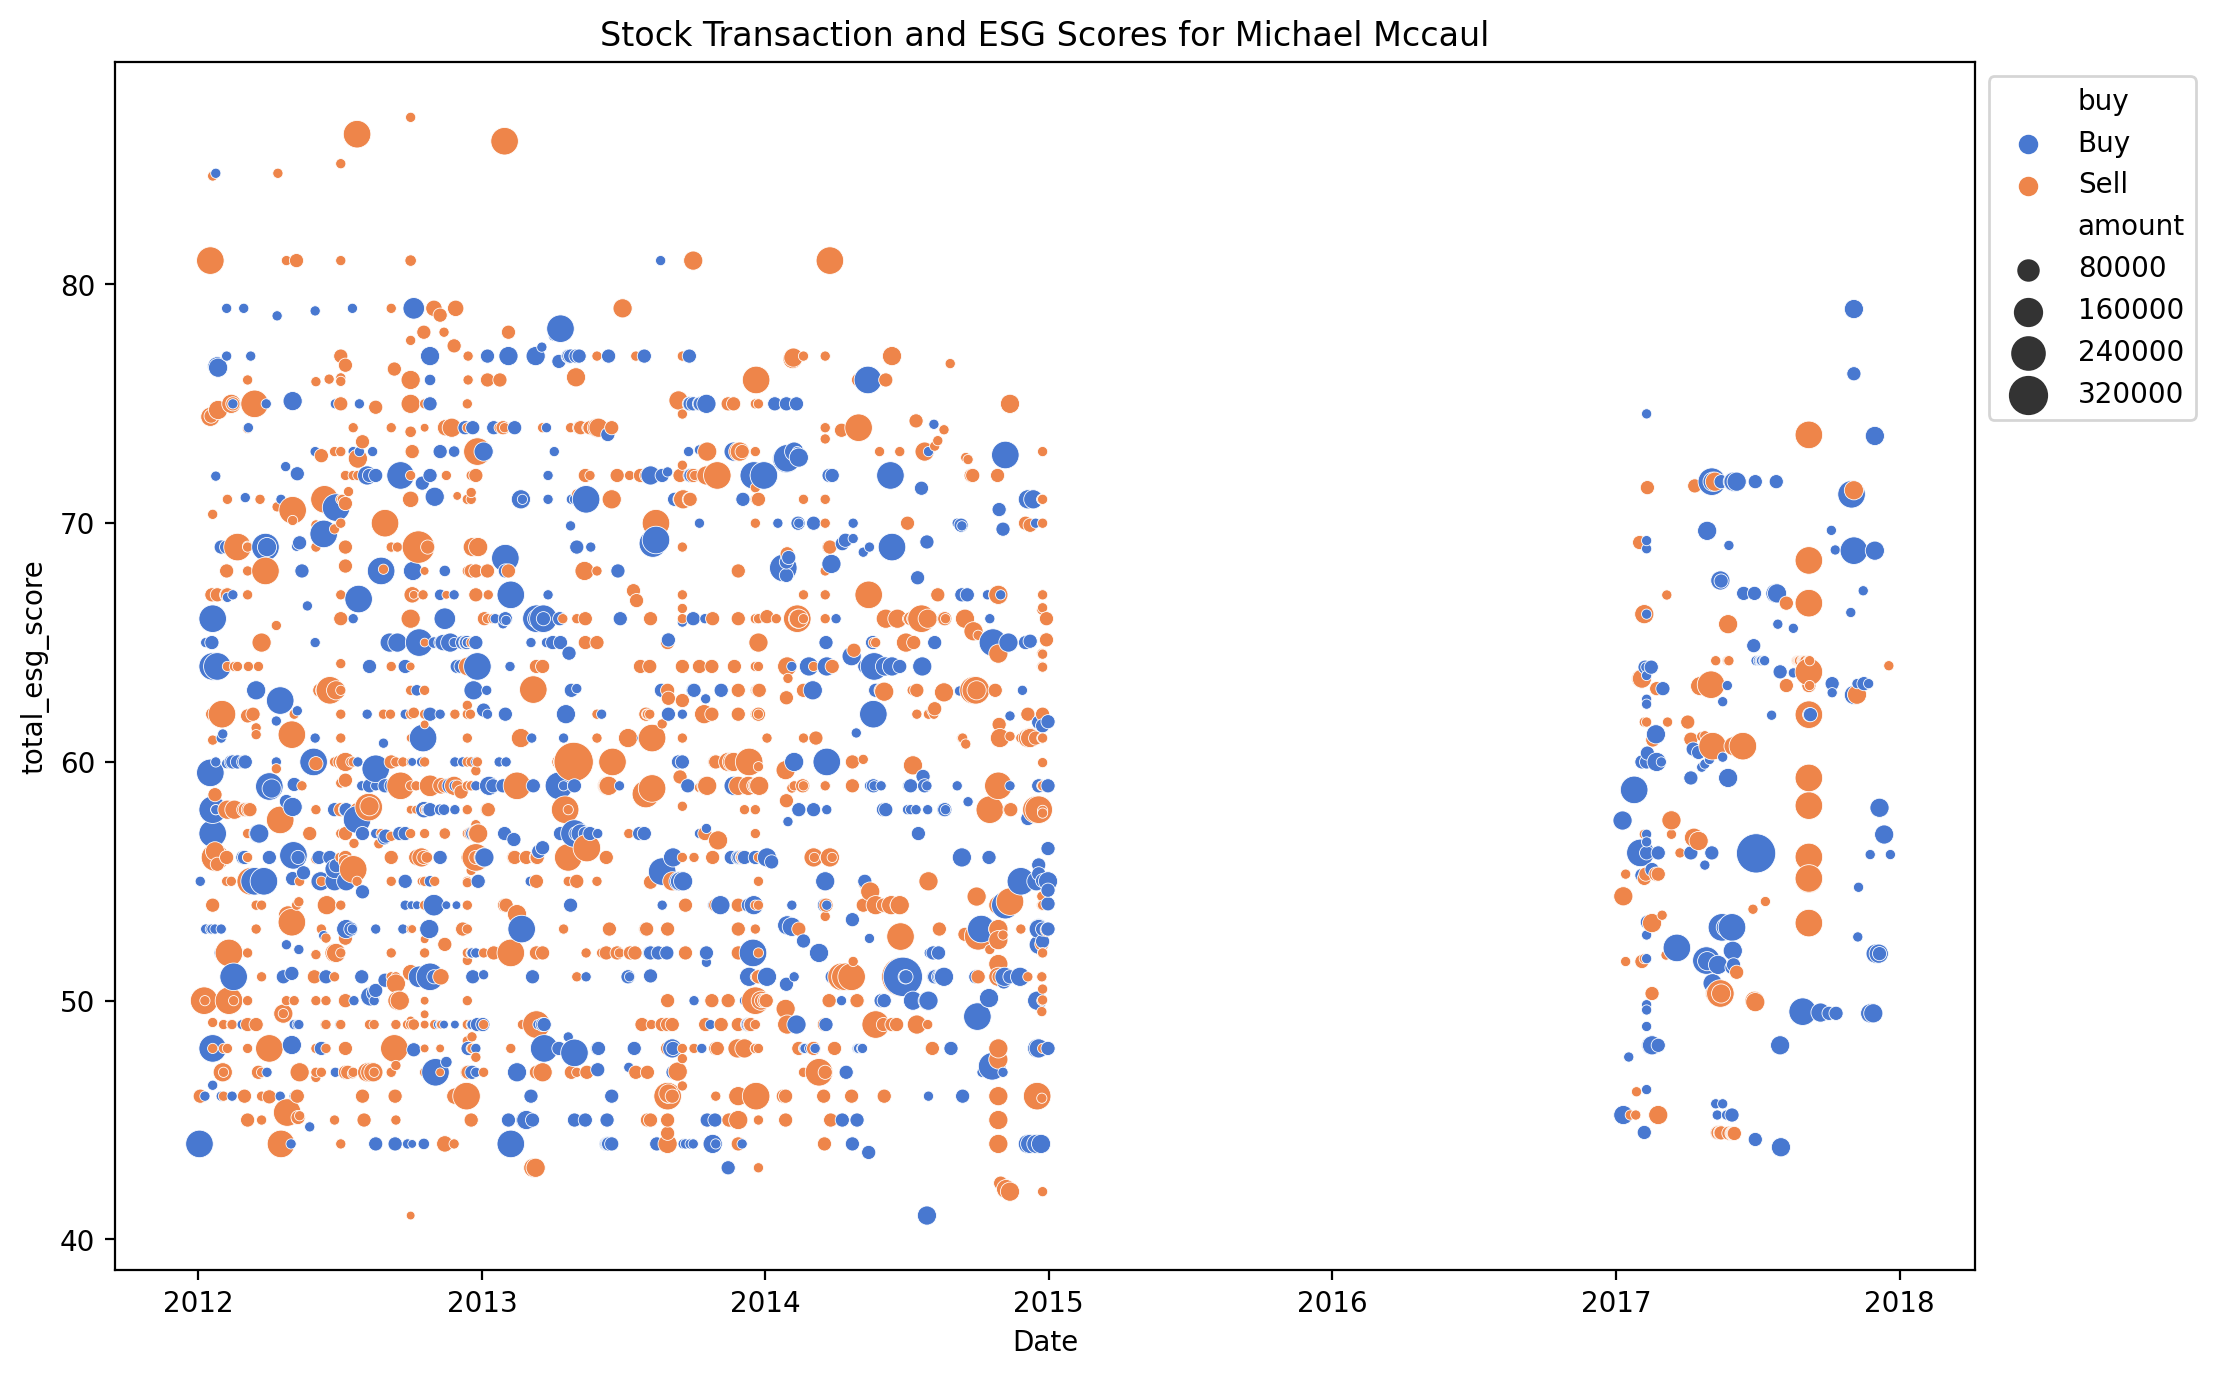

In [120]:
# Michael Mccaul performed the highest number of transactions in our dataset
plot_transaction_esg("H4TX10093") 

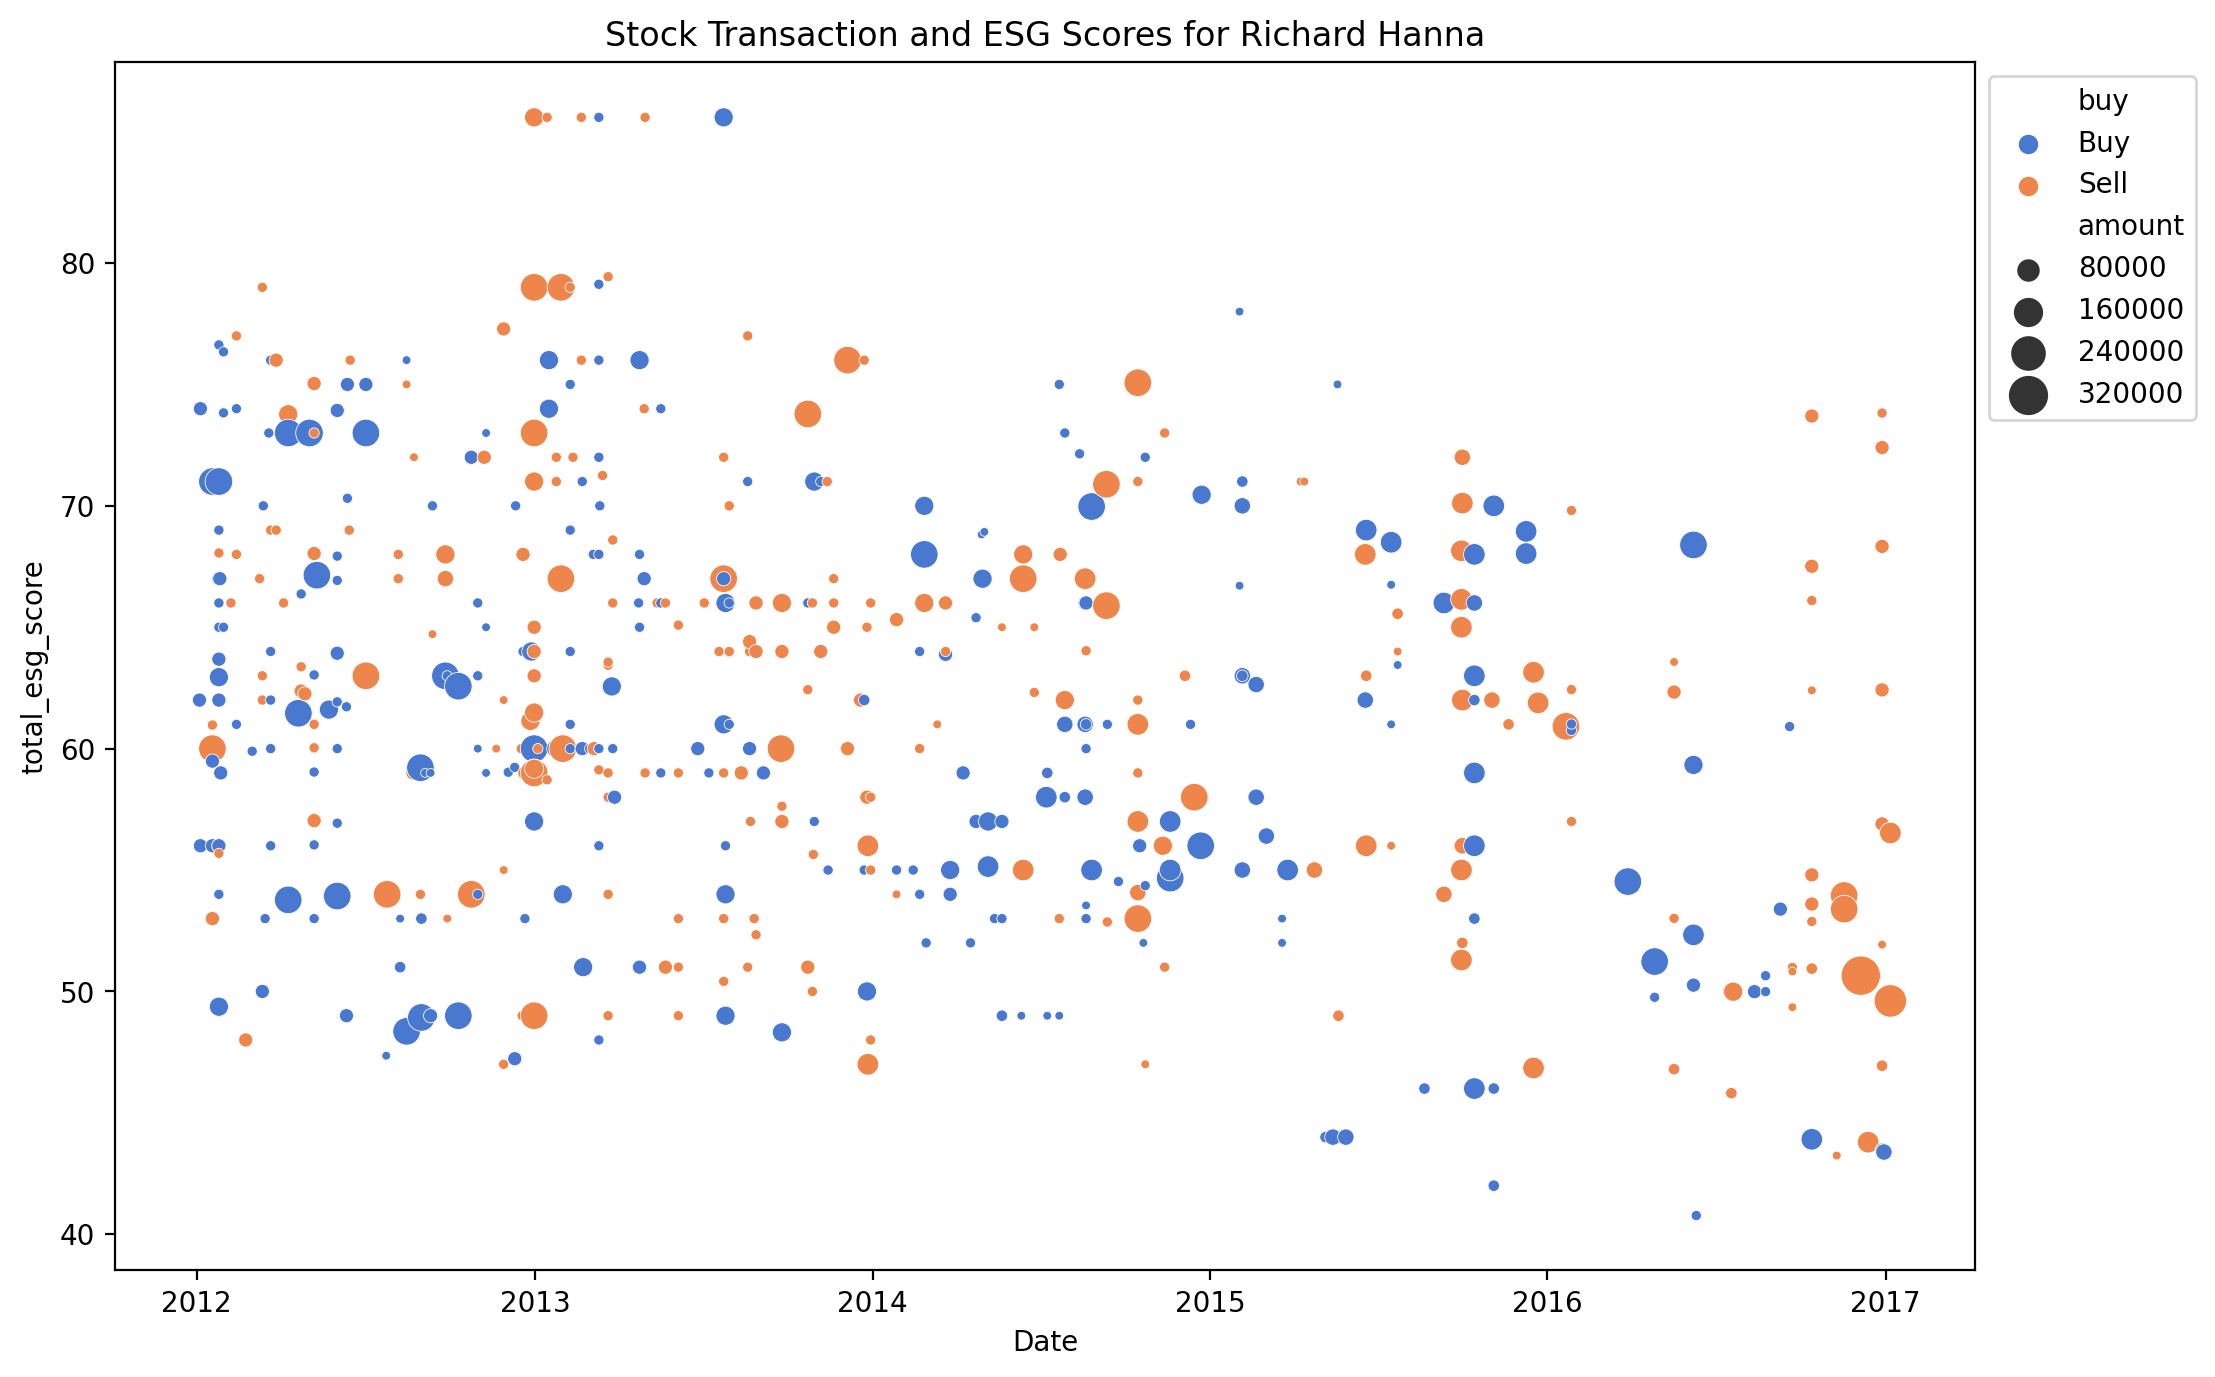

In [119]:
# plot random politician
plot_transaction_esg()